<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

### Datos
El objecto es utilizar datos disponibles de Anki de traducciones de texto en diferentes idiomas. Se construirá un modelo traductor seq2seq utilizando encoder-decoder.\
[LINK](https://www.manythings.org/anki/)

In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Métrica de accuracy con máscara de padding
def sequence_acc(logits, tgt_idx, pad_idx=0):
    """
    logits : [B, L, V]  salida del modelo
    tgt_idx: [B, L]     índices ground-truth
    """
    pred_idx = logits.argmax(dim=-1)
    mask     = tgt_idx.ne(pad_idx)            # True donde hay palabra
    correct  = (pred_idx.eq(tgt_idx) & mask).float()
    total = mask.sum()
    return correct.sum() / total if total > 0 else torch.tensor(0.0)

# Función de entrenamiento
def train(model,
          train_loader,
          valid_loader,
          optimizer,
          criterion,              
          epochs     = 50,
          patience   = 7,
          min_delta  = 1e-4,
          device     = "cuda",
          pad_idx    = 0):
    model.to(device)
    best_val_loss = float("inf")
    wait          = 0
    best_state    = None
    history = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}

    for epoch in range(1, epochs + 1):
        # ----- TRAIN -----
        model.train()
        tot_loss, tot_acc = 0, 0
        for enc_in, dec_in, tgt_idx in train_loader:
            enc_in   = enc_in.to(device)
            dec_in   = dec_in.to(device)
            tgt_idx  = tgt_idx.to(device)
            optimizer.zero_grad()
            logits = model(enc_in, dec_in)            # [B, L, V]
            B, L, V = logits.shape
            loss = criterion(logits.view(-1, V), tgt_idx.view(-1))
            loss.backward()
            optimizer.step()
            tot_loss += loss.item()
            tot_acc  += sequence_acc(logits, tgt_idx, pad_idx).item()
        train_loss = tot_loss / len(train_loader)
        train_acc  = tot_acc  / len(train_loader)

        # ----- VALID -----
        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for enc_in, dec_in, tgt_idx in valid_loader:
                enc_in  = enc_in.to(device)
                dec_in  = dec_in.to(device)
                tgt_idx = tgt_idx.to(device)
                logits = model(enc_in, dec_in)
                B, L, V = logits.shape
                loss = criterion(logits.view(-1, V), tgt_idx.view(-1))
                val_loss += loss.item()
                val_acc  += sequence_acc(logits, tgt_idx, pad_idx).item()
        val_loss /= len(valid_loader)
        val_acc  /= len(valid_loader)
        history["loss"].append(train_loss)
        history["accuracy"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        print(f"Epoch {epoch:3d}: "
              f"Train L={train_loss:.4f} A={train_acc:.4f} | "
              f"Val L={val_loss:.4f} A={val_acc:.4f}")

        # ----- EARLY STOPPING -----
        if val_loss + min_delta < best_val_loss:
            best_val_loss = val_loss
            best_state    = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history, model

### 1 - Datos

In [ ]:
# dataset_file
text_file = "./clase/spa-eng/spa.txt"
with open(text_file, encoding="utf8") as f:
    lines = f.read().split("\n")[:-1]

# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 0

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

if MAX_NUM_SENTENCES == 0:
    MAX_NUM_SENTENCES = len(lines)
for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))
print(input_sentences[0], output_sentences[0], output_sentences_inputs[0])

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 118964


### 2 - Preprocesamiento

In [6]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 30000

In [7]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from clase.torch_helpers import Tokenizer
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 13524
Sentencia de entrada más larga: 47


In [8]:
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 26341
Sentencia de salida más larga: 50


Como era de esperarse, las sentencias en castellano son más largas que en inglés, y lo mismo sucede con su vocabulario.

A la hora de realiza padding es importante teneer en cuenta que en el encoder los ceros se agregan al comienoz y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [ ]:
from clase.torch_helpers import pad_sequences
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

Cantidad de rows del dataset: 118964
encoder_input_sequences shape: (118964, 47)
decoder_input_sequences shape: (118964, 50)


Cargamos un dataset sin one_hot encoding para ocupar menos memoria

In [14]:
class Seq2SeqDataset(Dataset):
    """
    Devuelve tensores int64 con PAD=0.
    ─ encoder_inputs : [N, T_enc]
    ─ decoder_inputs : [N, T_dec]   (<sos> + frase)
    ─ decoder_outputs: [N, T_dec]   (frase + <eos>)
    """
    def __init__(self, enc_arr: np.ndarray,
                       dec_in_arr: np.ndarray,
                       dec_out_arr: np.ndarray):

        # Convertir a tensores int64
        self.encoder_inputs  = torch.from_numpy(enc_arr    .astype(np.int64))
        self.decoder_inputs  = torch.from_numpy(dec_in_arr .astype(np.int64))
        self.decoder_outputs = torch.from_numpy(dec_out_arr.astype(np.int64))

        assert len(self.encoder_inputs) == len(self.decoder_inputs) == len(self.decoder_outputs), \
            "Los tres arrays deben tener la misma longitud"

    def __getitem__(self, idx):
        return (self.encoder_inputs [idx],
                self.decoder_inputs [idx],
                self.decoder_outputs[idx])

    def __len__(self):
        return len(self.encoder_inputs)
    
# Construcción
data_set = Seq2SeqDataset(encoder_input_sequences,
                          decoder_input_sequences,
                          decoder_output_sequences)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("decoder_input_size:", decoder_input_size)

output_dim = data_set.decoder_outputs.shape[1]
print("Output dim", output_dim)

encoder_input_size: 47
decoder_input_size: 50
Output dim 50


In [ ]:
torch.manual_seed(42)
valid_set_size = int(len(data_set) * 0.2)
train_set_size = len(data_set) - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, len(data_set)))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

Tamaño del conjunto de entrenamiento: 95172
Tamaño del conjunto de validacion: 23792


### 3 - Preparar los embeddings

Se utilizan dos embeddings pre entrenados de Fastext para el ingles y el español

In [16]:
from gensim.models.fasttext import load_facebook_vectors
model_embeddings = load_facebook_vectors("clase/cc.en.300.bin")  
from gensim.models.fasttext import load_facebook_vectors
model_embeddings_es = load_facebook_vectors("clase/cc.es.300.bin")

In [17]:
vocab_size_in  = max(word2idx_inputs .values()) + 1   
vocab_size_out = max(word2idx_outputs.values()) + 1   
embed_dim = 300
# Inglés
embedding_matrix = np.zeros((vocab_size_in, embed_dim), dtype=np.float32)
for w, idx in word2idx_inputs.items():
    # idx incluye todos los valores hasta max_index
    if w in model_embeddings:
        embedding_matrix[idx] = model_embeddings[w]
# Español
embedding_matrix_es = np.zeros((vocab_size_out, embed_dim), dtype=np.float32)
for w, idx in word2idx_outputs.items():
    if w in model_embeddings_es:
        embedding_matrix_es[idx] = model_embeddings_es[w]
print(embedding_matrix.shape)
print(embedding_matrix_es.shape)
nb_words = embedding_matrix.shape[0]
num_words_output = embedding_matrix_es.shape[0]

(13525, 300)
(26342, 300)


### 4 - Entrenar el modelo

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.lstm_size = 256
        self.num_layers = 2
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        self.lstm_size = 256
        self.num_layers = 2
        self.embedding_dim = embed_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix_es))
        self.embedding.weight.requires_grad = True  # Opcional: Freezar
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.fc1(lstm_output)  # conserva la dimensión de secuencia
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size, device=encoder_input.device)
        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)
        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]
        for t in range(decoder_input_len):
            input = decoder_input[:, t:t+1]
            output, prev_state = self.decoder(input, prev_state)
            # top1 = output.argmax(1).view(-1, 1)
            top1 = output[:, -1, :].argmax(1).view(-1, 1)
            # guardar cada salida (softmax)
            outputs[:, t, :] = output.squeeze(1)
            # outputs[:, t, :] = output
        return outputs

In [ ]:
encoder = Encoder(vocab_size=nb_words)
if cuda: encoder.cuda()
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()
seq2seq = Seq2Seq(encoder, decoder).to(device)
if cuda: seq2seq.cuda()

# Diferentes learning rates para hacer fine tuning al embedding en español de Fasttext
emb_params   = list(decoder.embedding.parameters())            # solo embedding ES
other_params = [p for n, p in seq2seq.named_parameters()
                if "decoder.embedding" not in n]               # resto de la red
lr = 0.01
optimizer = torch.optim.AdamW(
    [
        {"params": emb_params,   "lr": lr*0.01},   # LR pequeño para embedding
        {"params": other_params, "lr": lr},   # LR normal resto
    ],
    betas=(0.9, 0.98),
    weight_decay=1e-4
)

criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Omito el padding para que no falsee la metrica

x_enc = data_set[0:1][0]
x_dec = data_set[0:1][1]
summary(seq2seq,
        input_data=(x_enc.to(device).long(), x_dec.to(device).long()),
        device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 50, 26342]            --
├─Encoder: 1-1                           [2, 1, 128]               --
│    └─Embedding: 2-1                    [1, 47, 300]              (4,057,500)
│    └─LSTM: 2-2                         [1, 47, 128]              352,256
├─Decoder: 1-2                           [1, 1, 26342]             --
│    └─Embedding: 2-3                    [1, 1, 300]               7,902,600
│    └─LSTM: 2-4                         [1, 1, 128]               352,256
│    └─Linear: 2-5                       [1, 1, 26342]             3,398,118
├─Decoder: 1-3                           [1, 1, 26342]             (recursive)
│    └─Embedding: 2-6                    [1, 1, 300]               (recursive)
│    └─LSTM: 2-7                         [1, 1, 128]               (recursive)
│    └─Linear: 2-8                       [1, 1, 26342]             (recursive)
├─Decoder: 1-4  

In [ ]:
history, model = train(seq2seq,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=100,
                device=device,
                patience=8
                )

Epoch   1: Train L=6.2033 A=0.1779 | Val L=5.7144 A=0.1995
Epoch   2: Train L=5.2496 A=0.2163 | Val L=4.9122 A=0.2481
Epoch   3: Train L=4.3242 A=0.2918 | Val L=4.1632 A=0.3234
Epoch   4: Train L=3.7008 A=0.3478 | Val L=3.8181 A=0.3664
Epoch   5: Train L=3.2961 A=0.3854 | Val L=3.6525 A=0.3906
Epoch   6: Train L=3.0076 A=0.4145 | Val L=3.5323 A=0.4099
Epoch   7: Train L=2.7864 A=0.4384 | Val L=3.4545 A=0.4264
Epoch   8: Train L=2.6082 A=0.4587 | Val L=3.4089 A=0.4375
Epoch   9: Train L=2.4689 A=0.4758 | Val L=3.3868 A=0.4475
Epoch  10: Train L=2.3569 A=0.4898 | Val L=3.3991 A=0.4493
Epoch  11: Train L=2.2644 A=0.5029 | Val L=3.3795 A=0.4573
Epoch  12: Train L=2.1928 A=0.5130 | Val L=3.3780 A=0.4583
Epoch  13: Train L=2.1235 A=0.5238 | Val L=3.4021 A=0.4613
Epoch  14: Train L=2.0659 A=0.5327 | Val L=3.3886 A=0.4676
Epoch  15: Train L=2.0163 A=0.5407 | Val L=3.4090 A=0.4669
Epoch  16: Train L=1.9841 A=0.5465 | Val L=3.4239 A=0.4728
Epoch  17: Train L=1.9444 A=0.5530 | Val L=3.4333 A=0.47

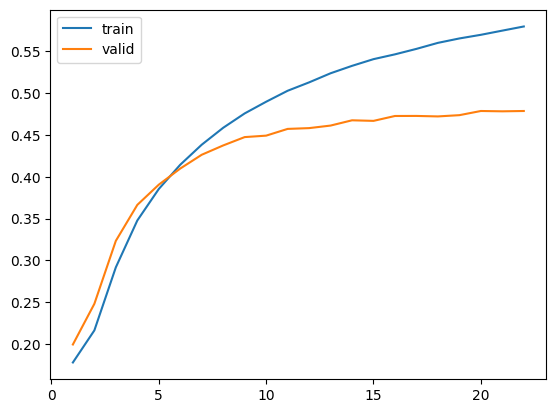

In [ ]:
epoch_count = range(1, len(history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia

In [147]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def translate_sentence(input_text, 
                       model, 
                       input_tokenizer, 
                       word2idx_outputs, 
                       idx2word_target,
                       max_input_len,
                       max_output_len,
                       device):
    model.eval()
    # 1) Tokenizar y paddear
    seq = input_tokenizer.texts_to_sequences([input_text.lower()])[0]
    seq = pad_sequences([seq], maxlen=max_input_len, padding='post')
    encoder_input = torch.tensor(seq, dtype=torch.long).to(device)      # [1, max_input_len]
    # 2) Pasar por el encoder
    prev_state = model.encoder(encoder_input)                           # (h, c)
    # 3) Iniciar decoder con <sos>
    sos = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    decoder_input = torch.tensor([[sos]], dtype=torch.long).to(device)  # [1, 1]
    output_words = []
    # 4) Loop hasta max_output_len o hasta <eos>
    for _ in range(max_output_len):
        logits, prev_state = model.decoder(decoder_input, prev_state)
        # logits: [1, 1, vocab_size]
        logits = logits.squeeze(1)           # [1, vocab_size]
        topi = logits.argmax(dim=1)          # [1]
        idx = topi.item()                    # entero
        if idx == eos:
            break
        output_words.append(idx2word_target[idx])
        # re-alimentar al decoder
        decoder_input = topi.unsqueeze(1)    # [1, 1]
    return ' '.join(output_words)



In [149]:
input_test = "My mother say hi."
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,  
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    My mother say hi.
Output:   él decidió hilo dental a la velocidad de tom y olviden que visitara boston


In [176]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,   
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    This movie is politically incorrect.
Output:   espero que tom gane el concierto antes de que se le ocurra matar a un canadiense


# Notas

- Se probó con redes más chicas de una capa, dos y tres. 
- Ampliando el estado oculto, con y sin dropout. 
- Sin filtrar le token de padding en el crossEntropy, el modelo daba mucho mejor accuracy, pero traducia muy mal. 
- Filtrando el padding, el accuracy da extremadamente bajo y sigue traduciendo igual de mal.